# Deep Learning with Keras and PyTorch

This notebook shows how to train a neural network using two different tools: Keras and PyTorch.

We use a dataset called `make_moons`. It is good for this because the data is not a straight line to separate.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 825.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 40.5 MB/s eta 0:00:00


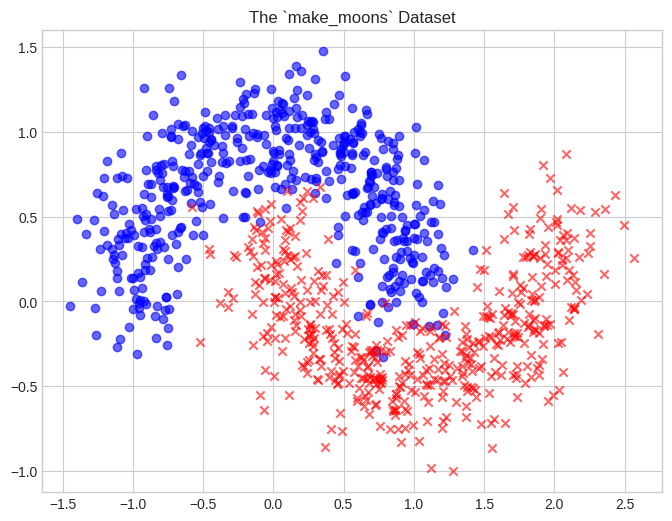

Train data shape: (800, 2), Test data shape: (200, 2)


In [1]:
!pip install -q tensorflow torch torchmetrics matplotlib scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Make 1000 data points.
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Split data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show the data.
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', marker='o', alpha=0.6)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', marker='x', alpha=0.6)
plt.title('The `make_moons` Dataset')
plt.show()

print(f"Train data shape: {X_train_scaled.shape}, Test data shape: {X_test_scaled.shape}")

### **Keras Model**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Keras Model
Keras Test Accuracy: 0.9800


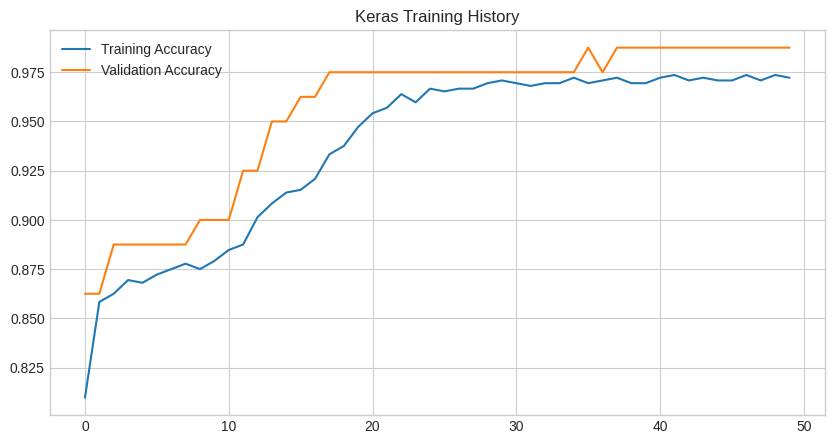

In [2]:
keras_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(2,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

keras_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

print("Training Keras Model")
history = keras_model.fit(X_train_scaled, y_train,
                          epochs=50,
                          batch_size=32,
                          validation_split=0.1,
                          verbose=0)

loss_keras, accuracy_keras = keras_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Keras Test Accuracy: {accuracy_keras:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Keras Training History')
plt.legend()
plt.show()

### **PyTorch Model**

In [3]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

class MoonNet(nn.Module):
    def __init__(self):
        super(MoonNet, self).__init__()
        self.layer1 = nn.Linear(2, 64)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

pytorch_model = MoonNet()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.01)

print("\n--- Training PyTorch Model ---")
epochs = 50
for epoch in range(epochs):
    pytorch_model.train()
    y_pred = pytorch_model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

pytorch_model.eval()
with torch.no_grad():
    y_pred_test = pytorch_model(X_test_tensor)
    predictions = (y_pred_test > 0.5).float()
    accuracy_pytorch = (predictions.squeeze() == y_test_tensor.squeeze()).float().mean()

print(f"PyTorch Test Accuracy: {accuracy_pytorch.item():.4f}")


--- Training PyTorch Model ---
Epoch [10/50], Loss: 0.2921
Epoch [20/50], Loss: 0.2270
Epoch [30/50], Loss: 0.1573
Epoch [40/50], Loss: 0.0968
Epoch [50/50], Loss: 0.0756
PyTorch Test Accuracy: 0.9850


### **Decision Boundary Plots**

These plots show how the models learned to divide the data. A wavy line is good for this dataset.

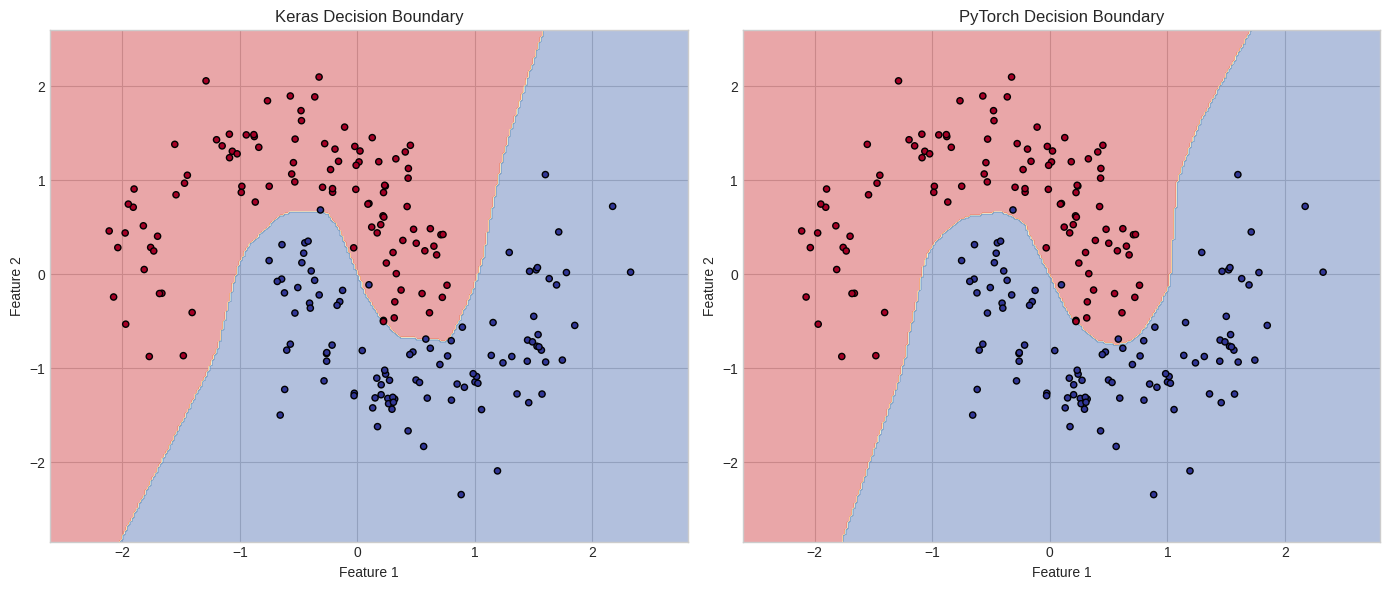

In [4]:
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    if isinstance(model, keras.Sequential):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0)
        Z = (Z > 0.5).astype(int)
    else:
        model.eval()
        with torch.no_grad():
            tensor_data = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
            Z = model(tensor_data).numpy()
            Z = (Z > 0.5).astype(int)

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_decision_boundary(keras_model, X_test_scaled, y_test, 'Keras Decision Boundary')

plt.subplot(1, 2, 2)
plot_decision_boundary(pytorch_model, X_test_scaled, y_test, 'PyTorch Decision Boundary')

plt.tight_layout()
plt.show()

I liked Keras more for this. It was faster to write. The code is simple to read. I just used model.fit() and it trained.

PyTorch needed more work. It gives more power, but for a simple project, Keras is much faster to use.

So, for simple things, Keras is the best choice for me.